# XRF laminography data from beamline 2-ID-E

In [1]:
import os
import numpy as np
import pyxalign
results_folder = "/local/hruth/2ide_xrf_example_results/"

## Load the XRF data

In [3]:
# create alias
xrf_load = pyxalign.io.loaders.xrf
# setup loading options
base = xrf_load.XRFBaseLoadOptions(folder="/net/micdata/data1/2ide/2025-1/Lamni-4/fine/")
load_options = xrf_load.XRF2IDELoadOptions(base=base)
load_options._mda_file_pattern = r"2xfm_(\d+)\.mda.h5"
# load xrf data
xrf_standard_data_dict = xrf_load.load_data_from_xrf_format(load_options)

# print loaded channels
channels = list(xrf_standard_data_dict.keys())
print(f"Loaded channels: {channels}")

Loaded channels: ['Al', 'Si', 'Ar', 'Ti', 'Cr', 'Mn', 'Co', 'Ni', 'Cu', 'Tb_L', 'Tm_L', 'Hf_L', 'Ta_L', 'Hf_M', 'Cu_Cu', 'COMPTON_AMPLITUDE', 'COHERENT_SCT_AMPLITUDE', 'Num_Iter', 'Fit_Residual', 'Total_Fluorescence_Yield', 'Sum_Elastic_Inelastic']


The variable `xrf_standard_data_dict` is a python dictionary where each item has a key corresponding to the element channel, and each value is the loaded data in the standard format that pyxalign loads data into, i.e. `StandardData`.

Laminography Angle: 69.99993 degrees


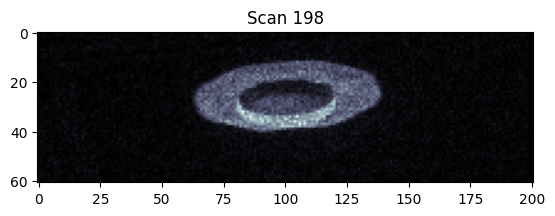

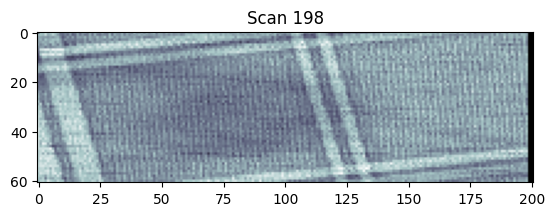

Scan range: 198 - 378
Number of projections: 181


In [4]:
# print the laminography angle, if it was loaded
if xrf_standard_data_dict["Ti"].lamino_angle is not None:
    lamino_angle = xrf_standard_data_dict["Ti"].lamino_angle
    print(f"Laminography Angle: {lamino_angle} degrees")
# plot some data using methods of StandardData
%matplotlib inline
xrf_standard_data_dict["Ti"].plot_sample_projection()
xrf_standard_data_dict["Cu"].plot_sample_projection()
# print some extra info
scan_start = xrf_standard_data_dict["Ti"].scan_numbers.min()
scan_end = xrf_standard_data_dict["Ti"].scan_numbers.max()
print(f"Scan range: {scan_start} - {scan_end}")
print(f"Number of projections: {len(xrf_standard_data_dict["Ti"].projections)}")

In [6]:
# use the interactive viewer to look at the titanium data
gui = pyxalign.gui.launch_standard_data_viewer(xrf_standard_data_dict["Ti"])

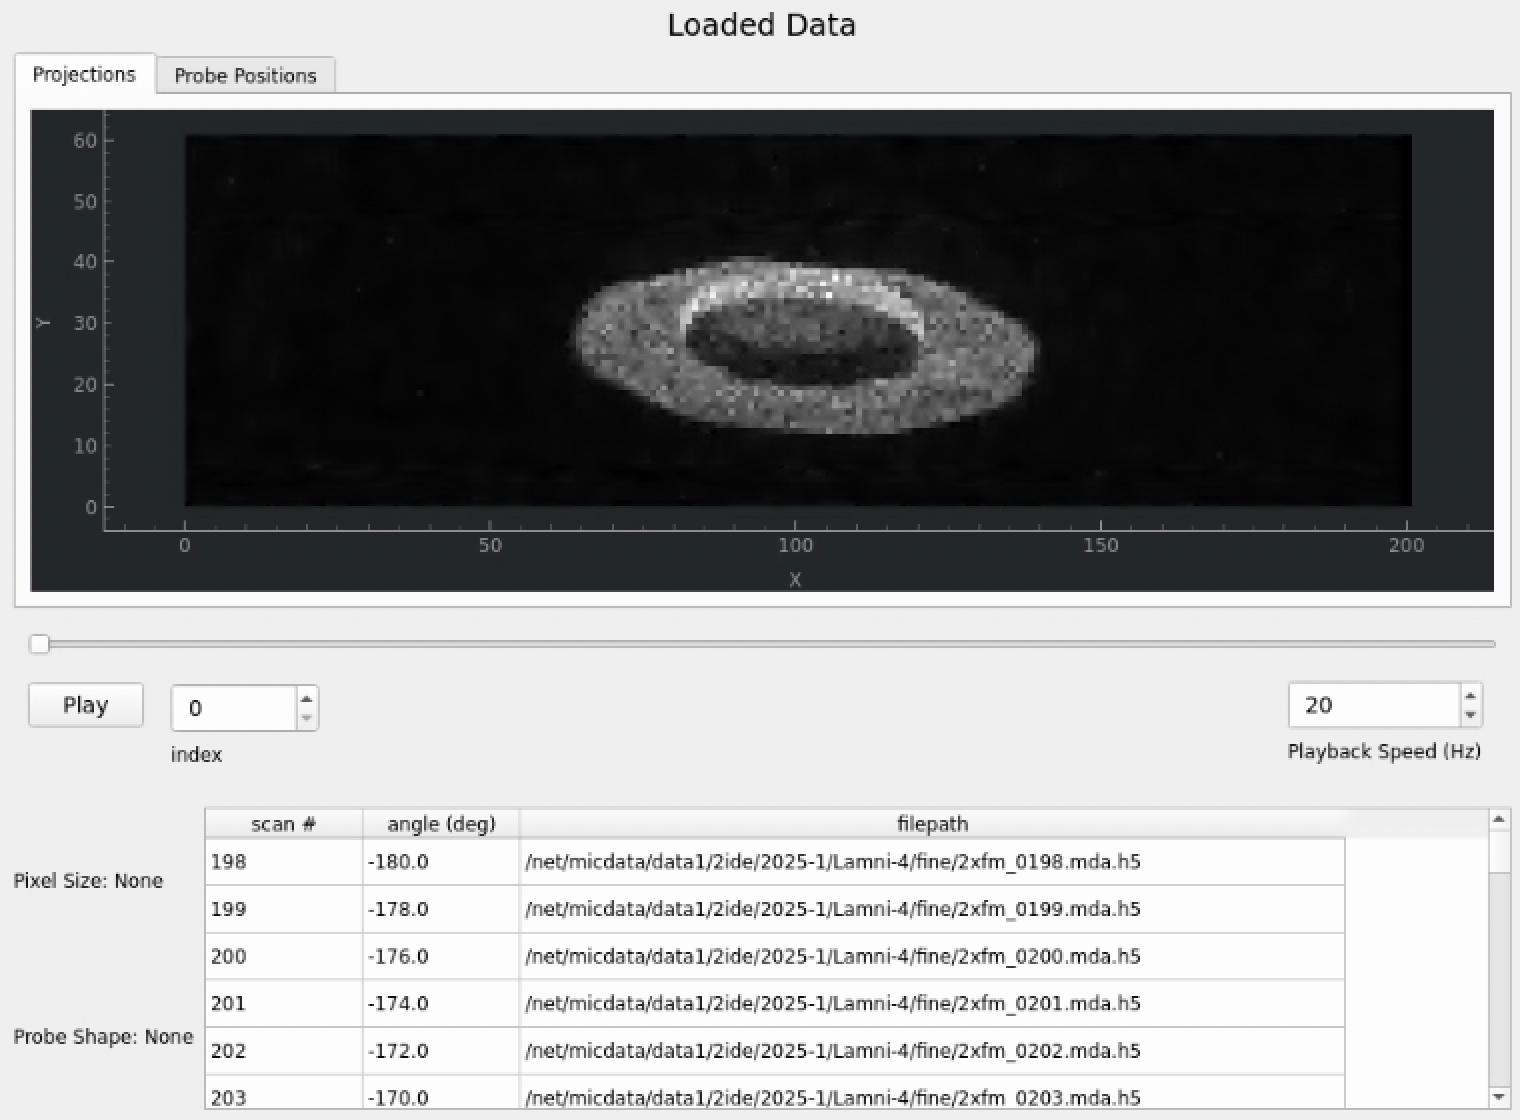

`xrf_standard_data_dict["Ti"].projections` is a dictionary of 2D arrays. 

Use `convert_xrf_projection_dicts_to_arrays` to convert the dictionary into a 3D array:

In [7]:
# create arrays from the data in the standardized format
xrf_array_dict = xrf_load.convert_xrf_projection_dicts_to_arrays(
    xrf_standard_data_dict,
    pad_with_mode=True,
)

  0%|                                                                                                                                                                                                                  | 0/21 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:02<00:00,  7.46it/s]

Projection array shape: (181, 64, 256)


## Create an `XRFTask` object

In [8]:
# specify projection options
projection_options = pyxalign.options.ProjectionOptions()
projection_options.experiment.laminography_angle = lamino_angle
projection_options.experiment.pixel_size = 1  # unknown for this dataset
projection_options.experiment.sample_thickness = 70  # an initial guess, can be updated later

# Pick the channel that will be used for alignment.
# The channel with the strongest and clearest features
# is typicall a good choice.
primary_channel = "Ti"

# Create the XRFTask object
xrf_task = pyxalign.data_structures.XRFTask(
    xrf_array_dict=xrf_array_dict,
    angles=xrf_standard_data_dict[primary_channel].angles,
    scan_numbers=xrf_standard_data_dict[primary_channel].scan_numbers,
    projection_options=projection_options,
    primary_channel=primary_channel,
    file_paths=list(xrf_standard_data_dict[primary_channel].file_paths.values()),
)

In [9]:
# save a copy of the task object that can be reloaded later
initial_xrf_task_path = os.path.join(results_folder, "initial_xrf_task.h5")
xrf_task.save_task(initial_xrf_task_path)

projections saved to /local/hruth/2ide_xrf_example_results/initial_xrf_task.h5/projections/Al
projections saved to /local/hruth/2ide_xrf_example_results/initial_xrf_task.h5/projections/Si
projections saved to /local/hruth/2ide_xrf_example_results/initial_xrf_task.h5/projections/Ar
projections saved to /local/hruth/2ide_xrf_example_results/initial_xrf_task.h5/projections/Ti
projections saved to /local/hruth/2ide_xrf_example_results/initial_xrf_task.h5/projections/Cr
projections saved to /local/hruth/2ide_xrf_example_results/initial_xrf_task.h5/projections/Mn
projections saved to /local/hruth/2ide_xrf_example_results/initial_xrf_task.h5/projections/Co
projections saved to /local/hruth/2ide_xrf_example_results/initial_xrf_task.h5/projections/Ni
projections saved to /local/hruth/2ide_xrf_example_results/initial_xrf_task.h5/projections/Cu
projections saved to /local/hruth/2ide_xrf_example_results/initial_xrf_task.h5/projections/Tb_L
projections saved to /local/hruth/2ide_xrf_example_results

In [ ]:
# reload the xrf task
xrf_task = pyxalign.data_structures.load_xrf_task(initial_xrf_task_path)

## Estimate the center of rotation

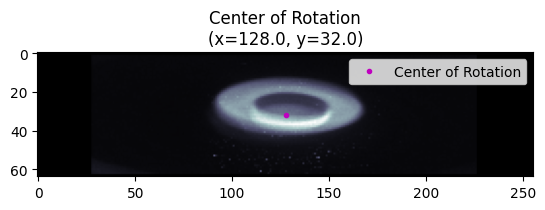

In [33]:
# plot the sum of projections and show the currently selected center of rotation
%matplotlib inline
xrf_task.projections_dict["Ti"].show_center_of_rotation()

Estimating the center of rotation by eye is usually good enough:

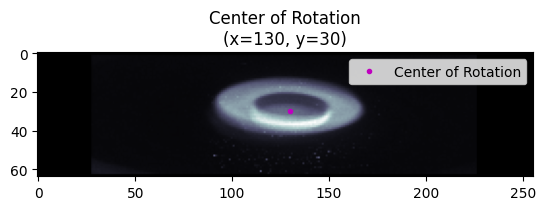

In [34]:
%matplotlib inline
xrf_task.center_of_rotation = [30, 130]  # y=30, x=130
xrf_task.projections_dict["Ti"].show_center_of_rotation()

## Open the XRF projections viewer

In [12]:
gui = pyxalign.gui.launch_xrf_projections_viewer(xrf_task)

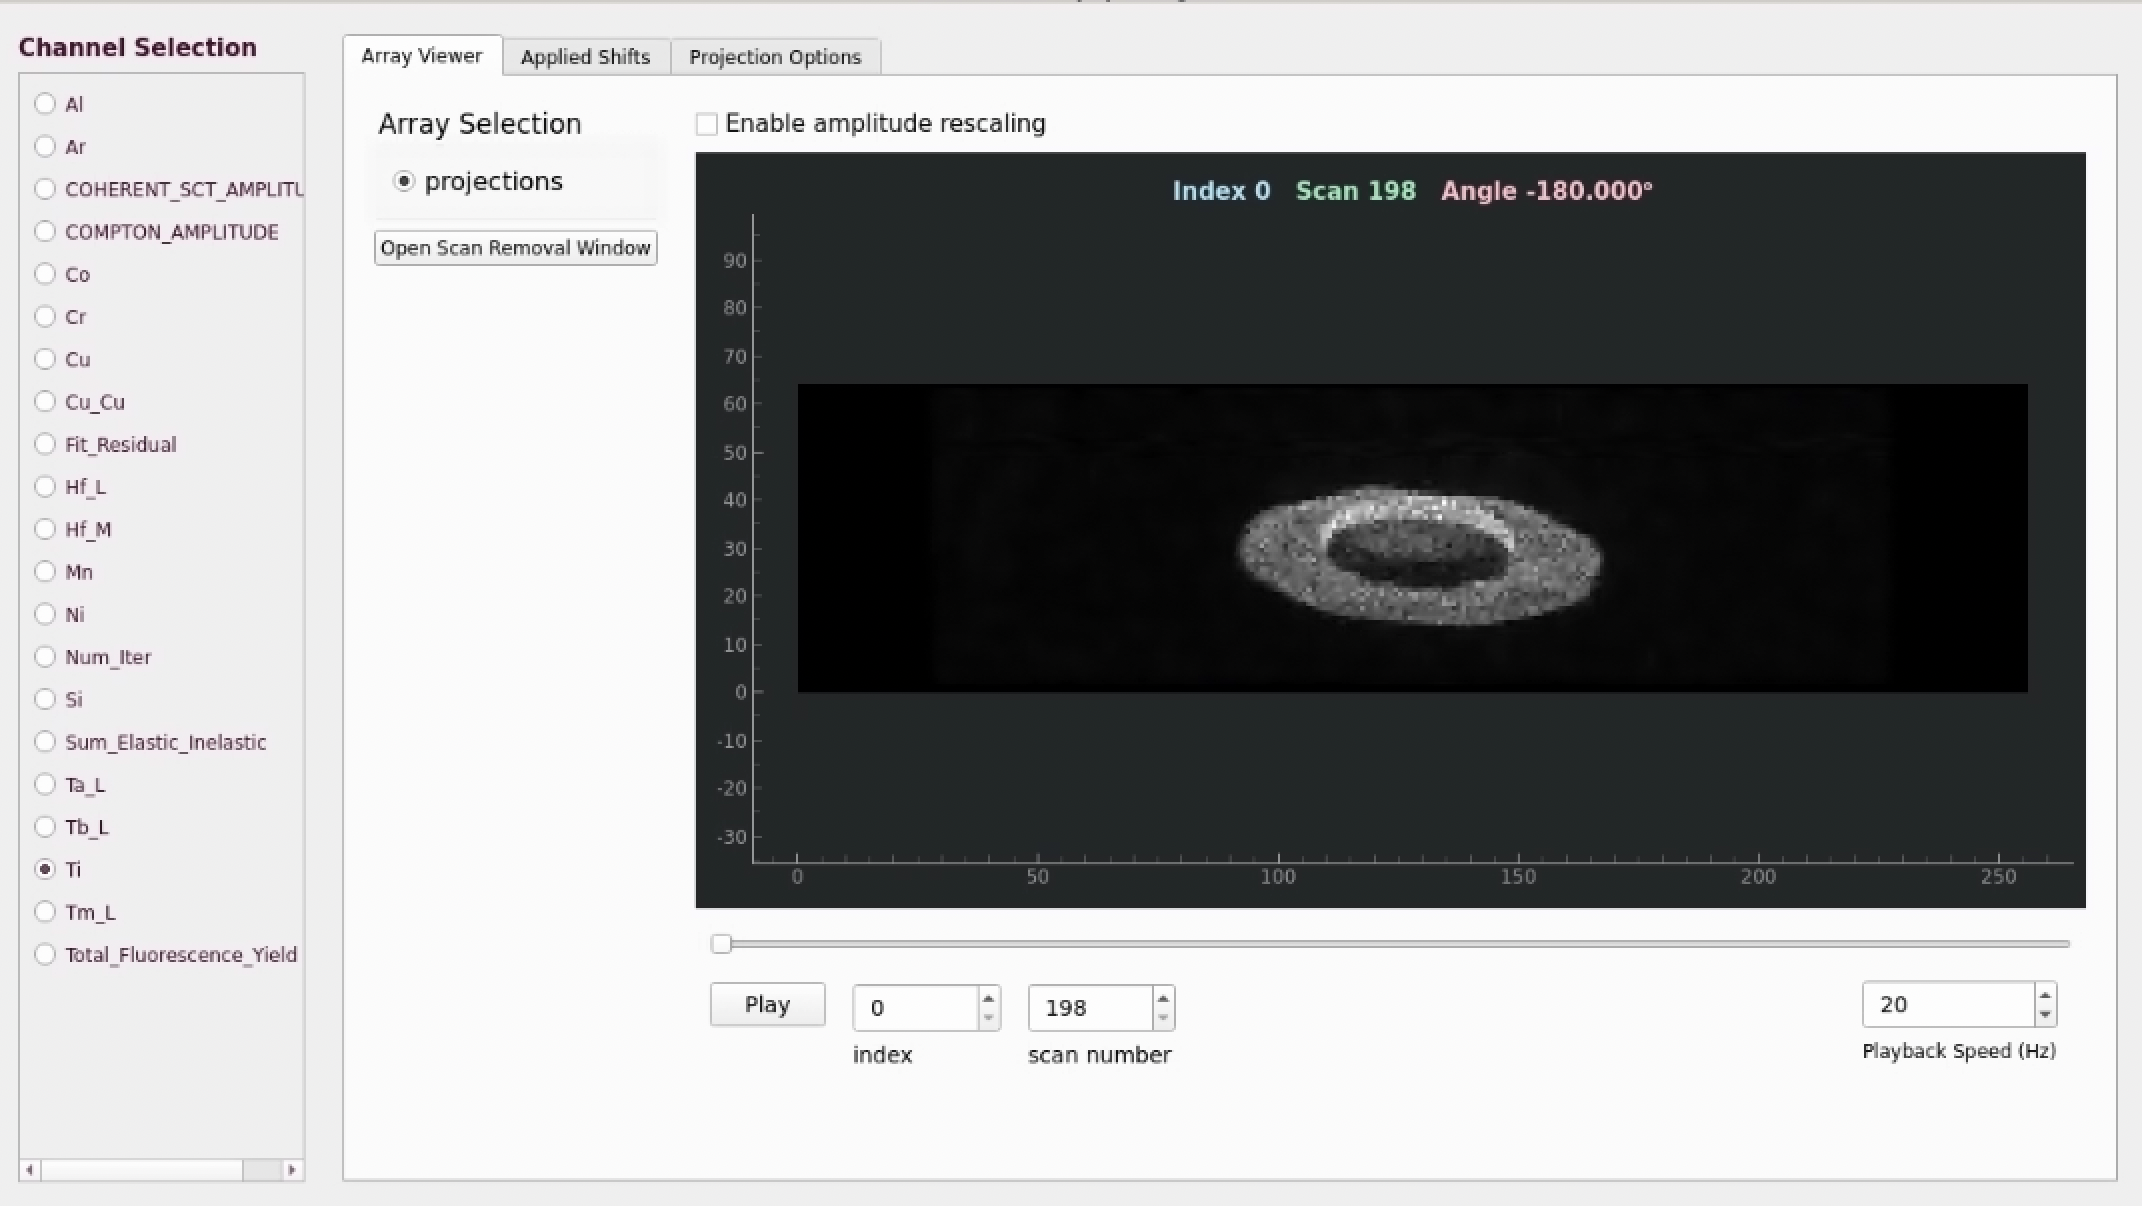

Remove scan 341 since it is bad (you can also do this via the gui by clicking the "open scan removal window" button)

In [36]:
xrf_task.drop_projections_from_all_channels(remove_scans=[341])

In [14]:
# create a masked region for projection matching alignment; this will be done
# automatically or with a GUI in the future
xrf_task.projections_dict[xrf_task._primary_channel].masks = np.ones_like(
    xrf_task.projections_dict[xrf_task._primary_channel].data
)

## Projection matching alignment

### Select appropriate settings

In [16]:
pma_options = xrf_task.alignment_options.projection_matching
pma_options.keep_on_gpu = True
pma_options.high_pass_filter = 0.001
pma_options.min_step_size = 0.005
pma_options.iterations = 1000
pma_options.downsample.enabled = True
pma_options.mask_shift_type = "fft"
pma_options.projection_shift_type = "fft"
pma_options.momentum.enabled = True
pma_options.interactive_viewer.update.enabled = True
pma_options.interactive_viewer.update.stride = 50
pma_options.prevent_wrapping_from_shift = True

### Run projection-matching alignment at multiple resolutions

Start the alignment for 2x downsampling

In [17]:
pma_options.downsample.scale = 2
shift = xrf_task.get_projection_matching_shift()

image_downsample_linear: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.59it/s]


Starting projection-matching alignment downsampling = 2...


Max step size update: 0.0050 px Momentum acceleration: [23.25 13.69] Friction: 0.03:  16%|██████████████████▌                                                                                              | 164/1000 [00:43<03:39,  3.81it/s]


Minimum step size reached, stopping loop...
Thread complete
Projection-matching shifts stored in shift_manager


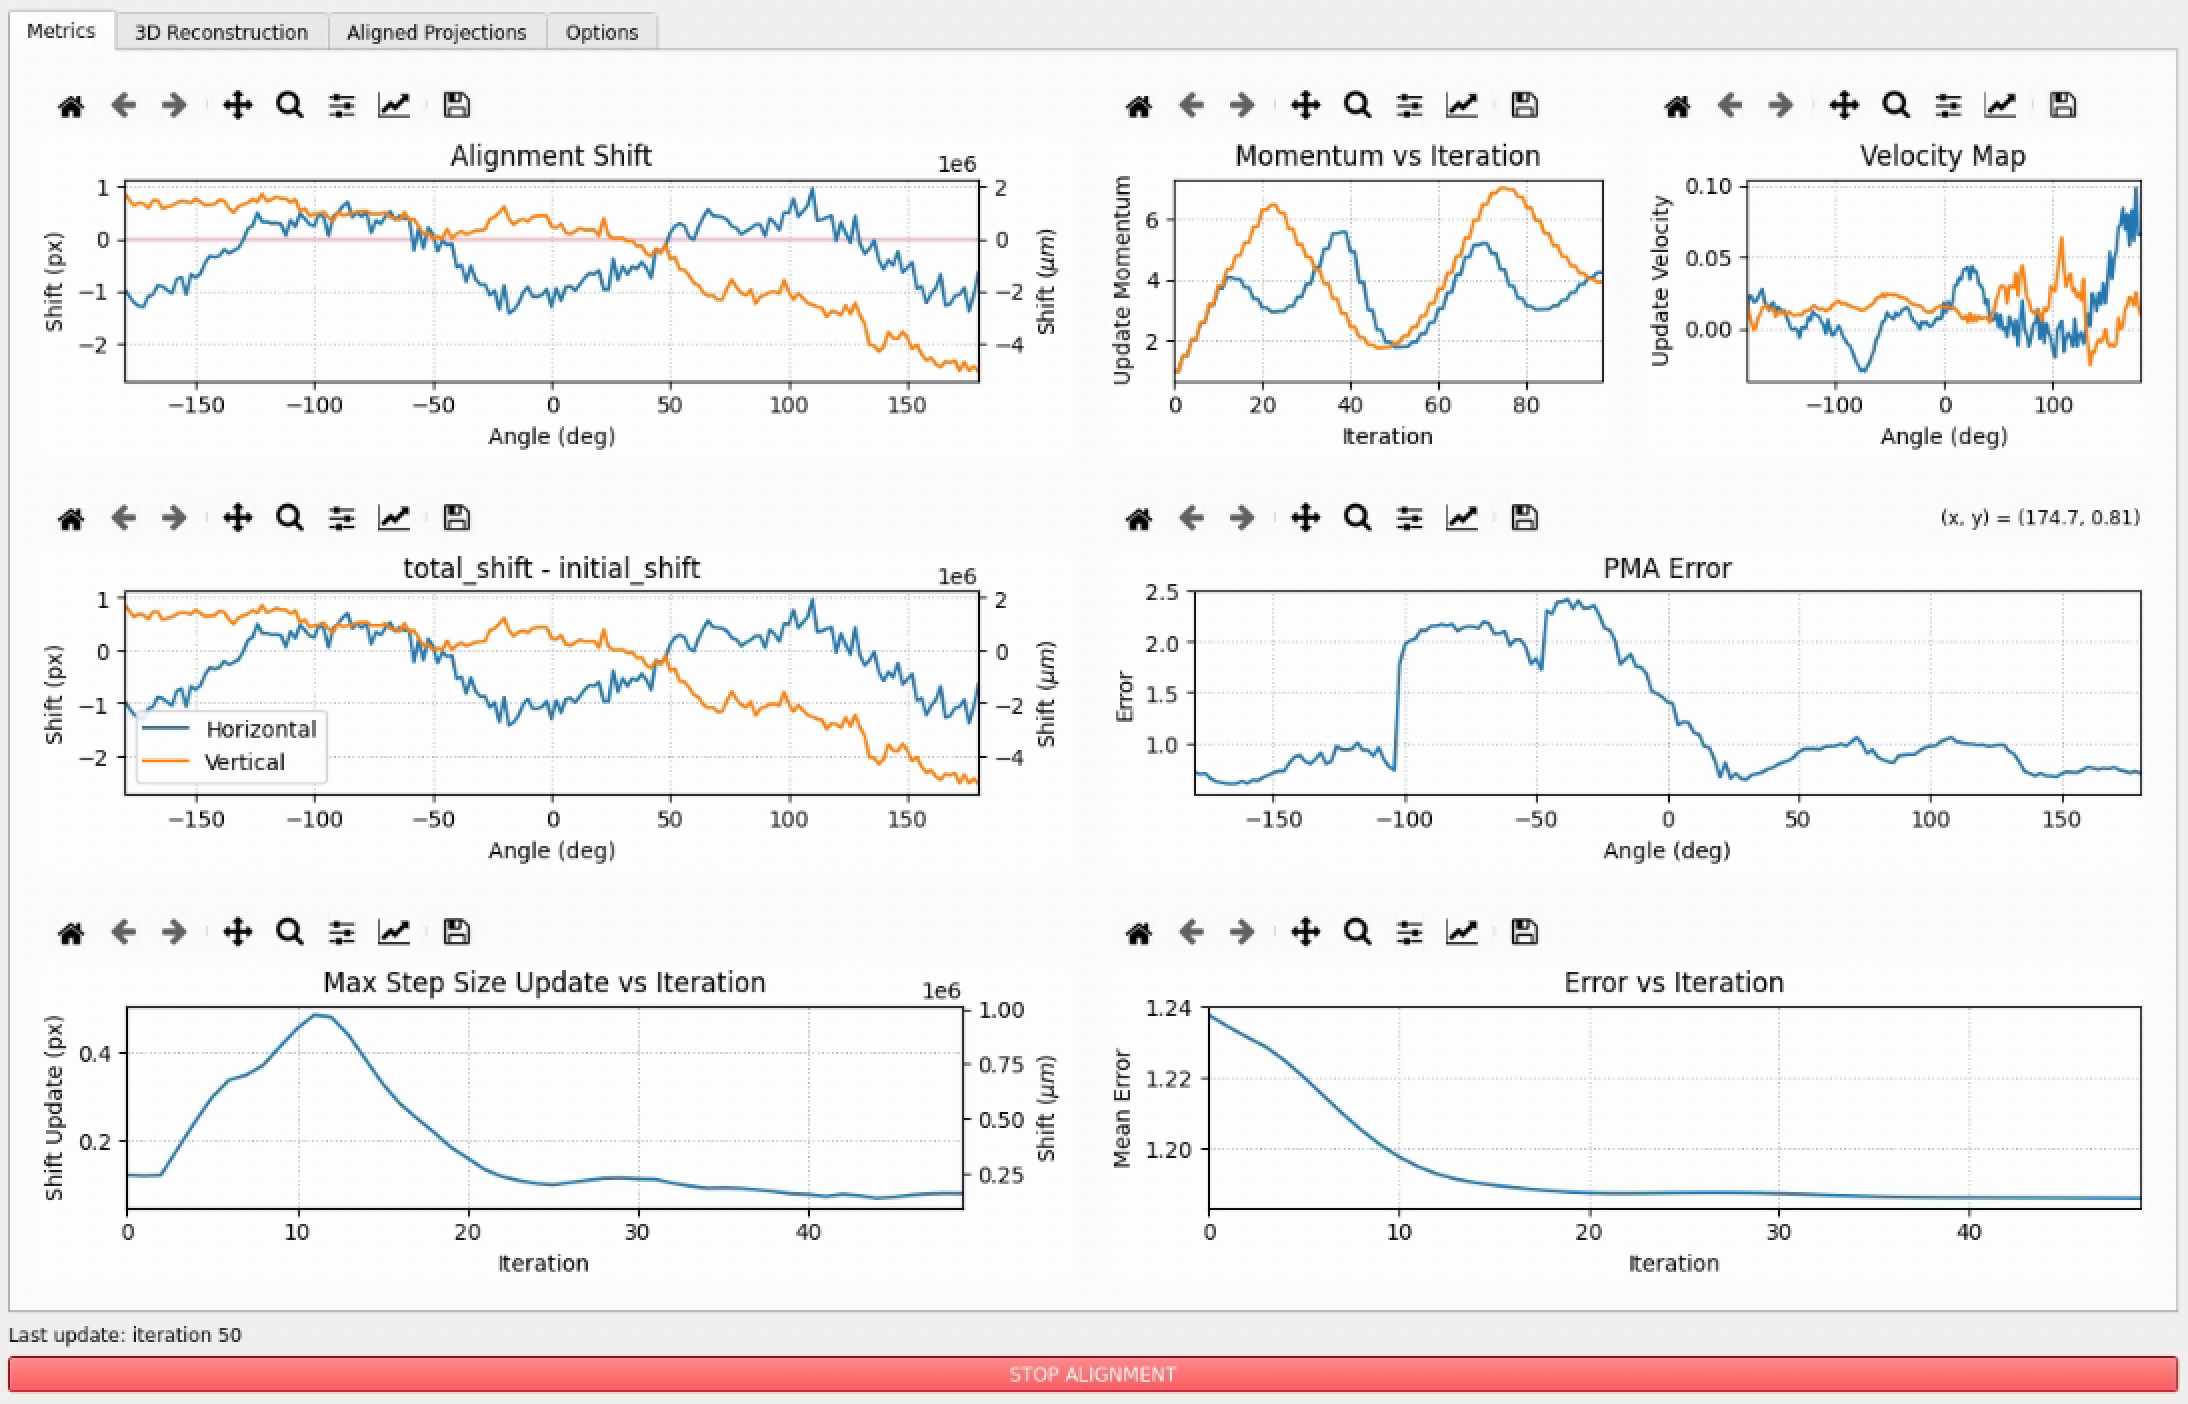

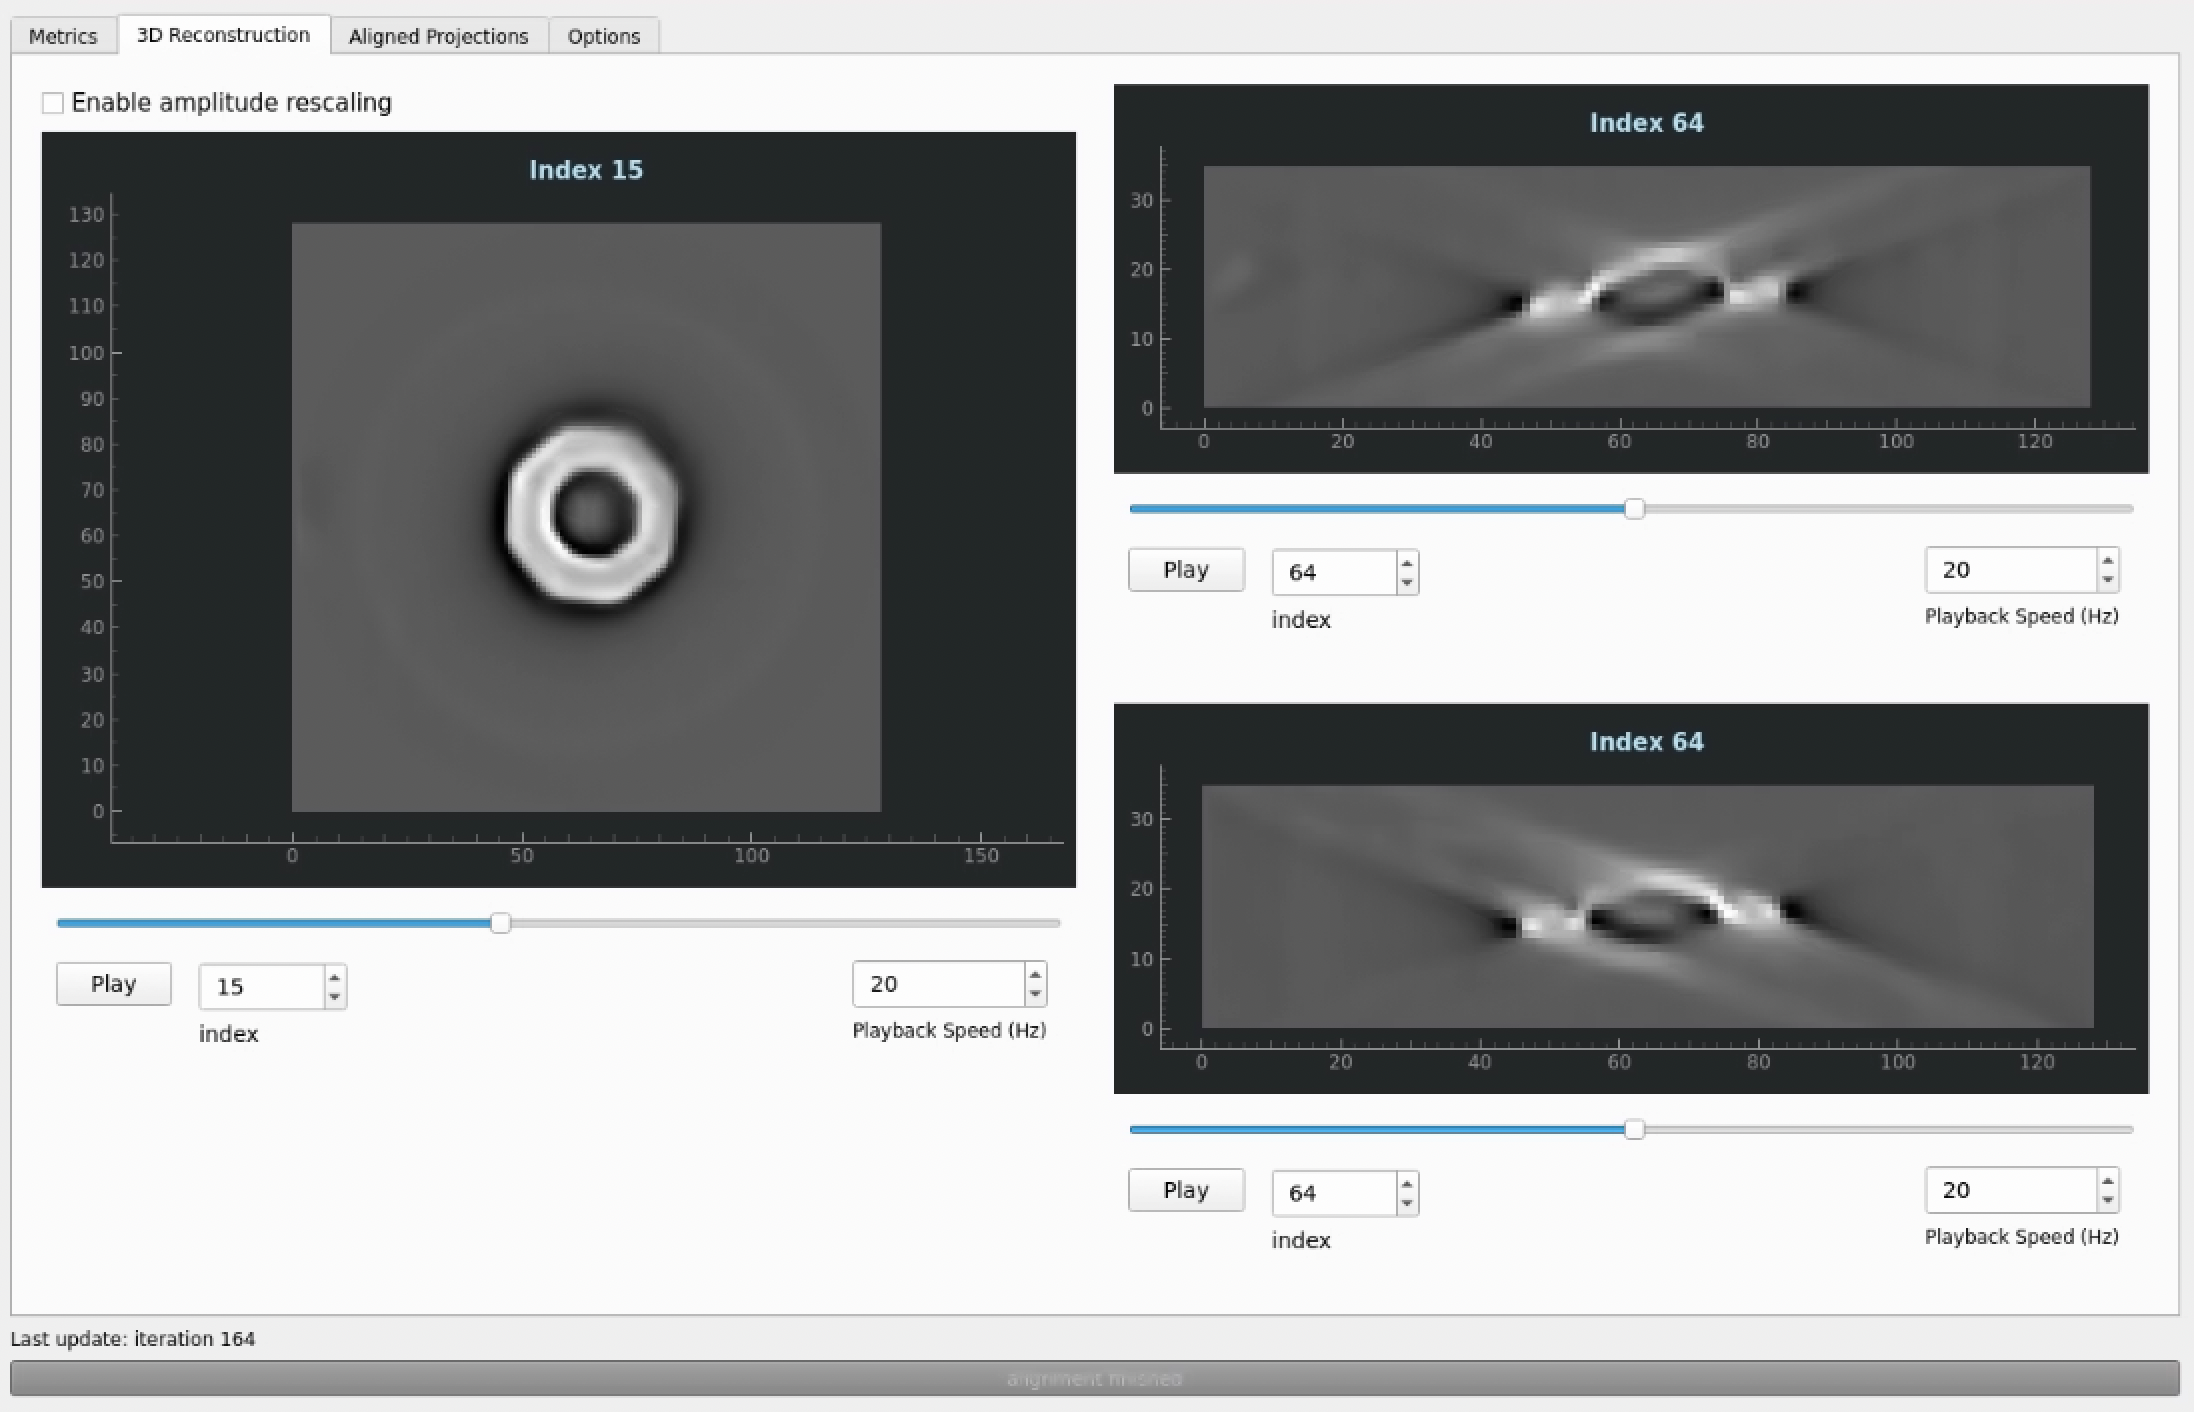

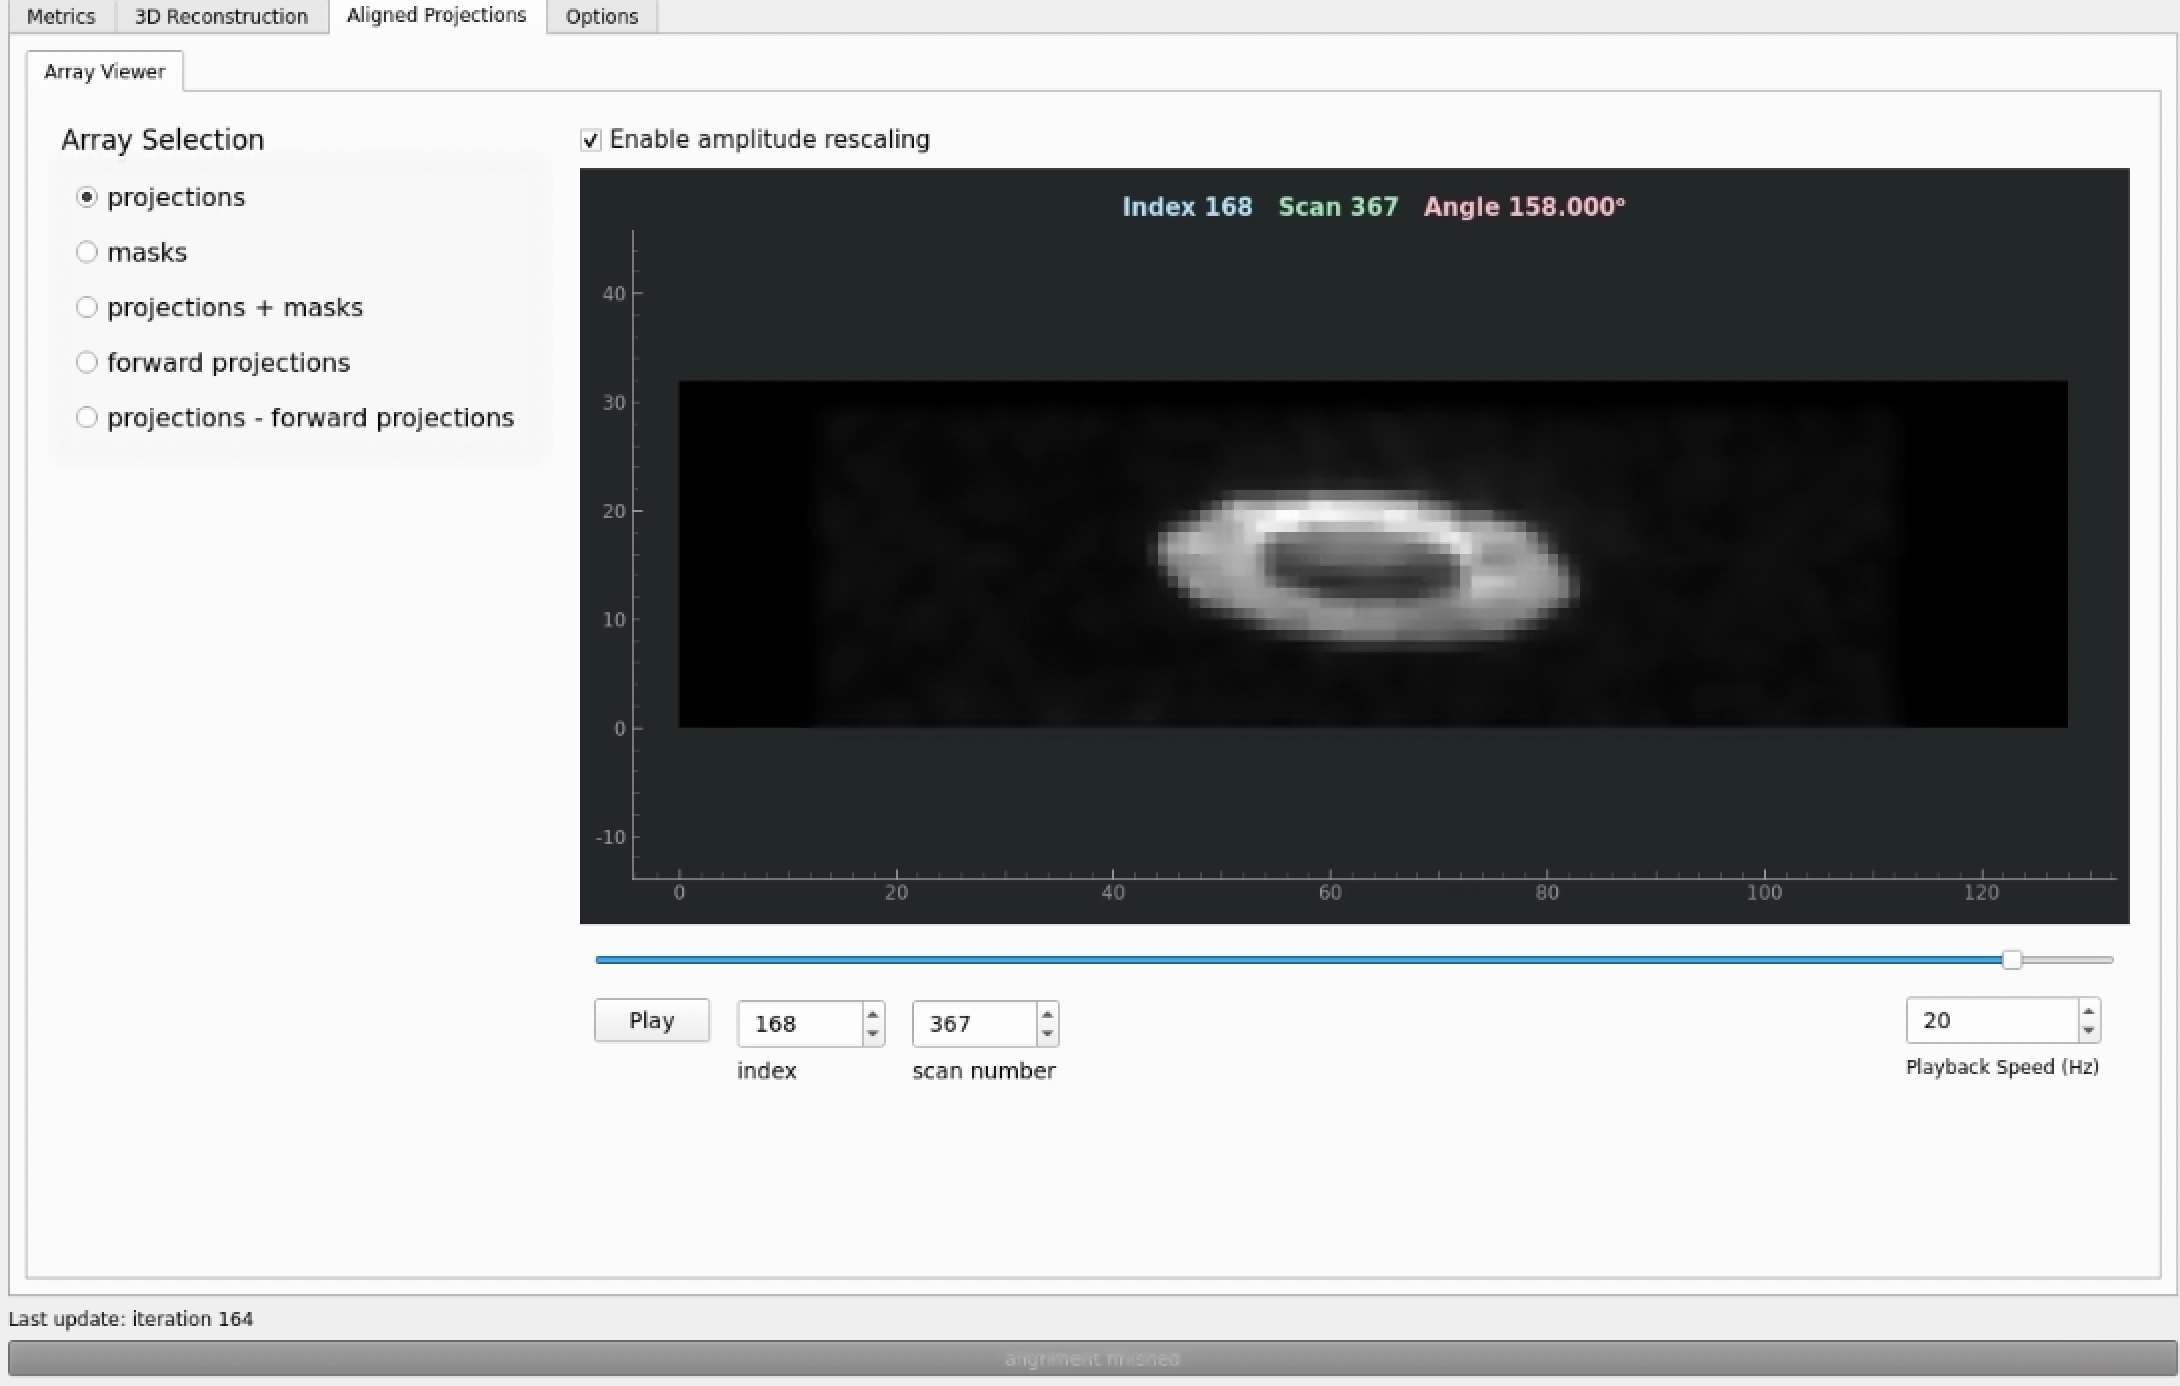

Run the alignment at full resolution

In [18]:
# run projection matching alignment at full resolution
pma_options.downsample.scale = 1
shift = xrf_task.get_projection_matching_shift(shift)

Starting projection-matching alignment downsampling = 1...


Max step size update: 0.0048 px Momentum acceleration: [10.73 13.49] Friction: 0.03:   9%|██████████                                                                                                        | 88/1000 [00:27<04:47,  3.18it/s]


Minimum step size reached, stopping loop...
Thread complete
Projection-matching shifts stored in shift_manager


### Apply alignment shift to the projections

In [19]:
# shift all projections
xrf_task.apply_staged_shift_to_all_channels()

### Save the aligned task

In [20]:
aligned_task_path = os.path.join(results_folder, "aligned_xrf_task.h5")
xrf_task.save_task(aligned_task_path)

projections saved to /local/hruth/2ide_xrf_example_results/aligned_xrf_task.h5/projections/Al
projections saved to /local/hruth/2ide_xrf_example_results/aligned_xrf_task.h5/projections/Ar
projections saved to /local/hruth/2ide_xrf_example_results/aligned_xrf_task.h5/projections/COHERENT_SCT_AMPLITUDE
projections saved to /local/hruth/2ide_xrf_example_results/aligned_xrf_task.h5/projections/COMPTON_AMPLITUDE
projections saved to /local/hruth/2ide_xrf_example_results/aligned_xrf_task.h5/projections/Co
projections saved to /local/hruth/2ide_xrf_example_results/aligned_xrf_task.h5/projections/Cr
projections saved to /local/hruth/2ide_xrf_example_results/aligned_xrf_task.h5/projections/Cu
projections saved to /local/hruth/2ide_xrf_example_results/aligned_xrf_task.h5/projections/Cu_Cu
projections saved to /local/hruth/2ide_xrf_example_results/aligned_xrf_task.h5/projections/Fit_Residual
projections saved to /local/hruth/2ide_xrf_example_results/aligned_xrf_task.h5/projections/Hf_L
projection

## Get 3D reconstructions

In [21]:
xrf_task.get_3D_reconstructions_for_all_channels()

### Launch the XRF volume viewer

In [25]:
gui = pyxalign.gui.launch_xrf_volume_viewer(xrf_task)

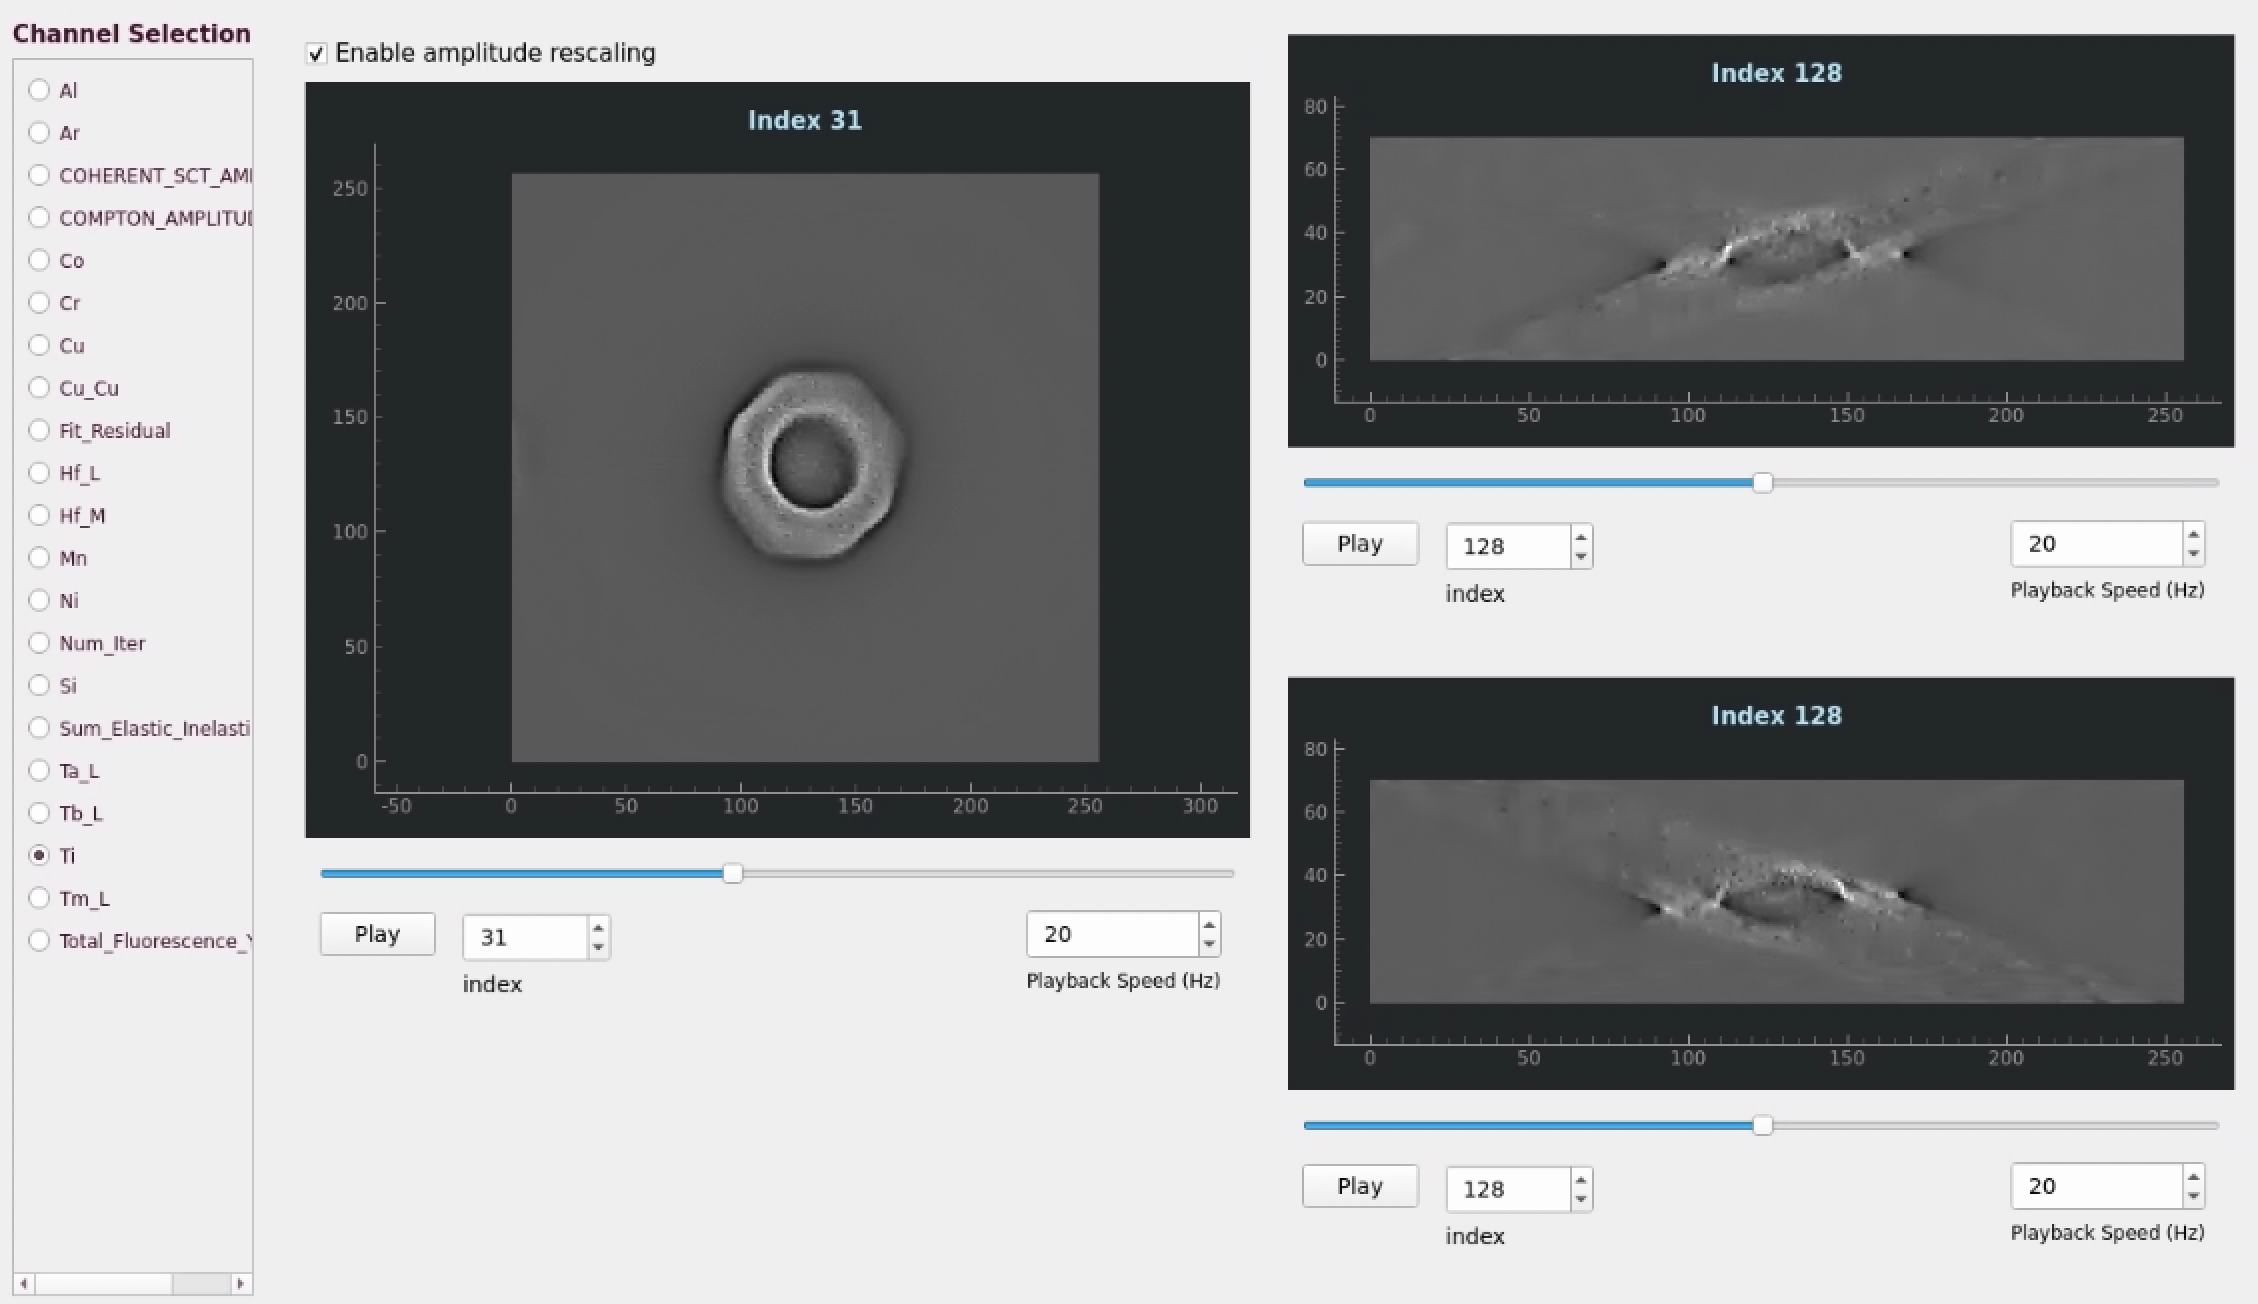

### Save a .tiff file for each channel

In [28]:
xrf_task.save_volumes_as_tiffs(results_folder=results_folder, file_prefix="aligned_volume_")

File saved to: /local/hruth/2ide_xrf_example_results/aligned_volume_Al.tiff
File saved to: /local/hruth/2ide_xrf_example_results/aligned_volume_Ar.tiff
File saved to: /local/hruth/2ide_xrf_example_results/aligned_volume_COHERENT_SCT_AMPLITUDE.tiff
File saved to: /local/hruth/2ide_xrf_example_results/aligned_volume_COMPTON_AMPLITUDE.tiff
File saved to: /local/hruth/2ide_xrf_example_results/aligned_volume_Co.tiff
File saved to: /local/hruth/2ide_xrf_example_results/aligned_volume_Cr.tiff
File saved to: /local/hruth/2ide_xrf_example_results/aligned_volume_Cu.tiff
File saved to: /local/hruth/2ide_xrf_example_results/aligned_volume_Cu_Cu.tiff
File saved to: /local/hruth/2ide_xrf_example_results/aligned_volume_Fit_Residual.tiff
File saved to: /local/hruth/2ide_xrf_example_results/aligned_volume_Hf_L.tiff
File saved to: /local/hruth/2ide_xrf_example_results/aligned_volume_Hf_M.tiff
File saved to: /local/hruth/2ide_xrf_example_results/aligned_volume_Mn.tiff
File saved to: /local/hruth/2ide_xrf